# VAR, VARMA and VARMAX
Author: Geovanna Santos Nobre de Oliveira

## VAR

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [3]:
plt.rcParams['figure.figsize'] = [20, 10]


### United States Macroeconomic Dataset

In [4]:
macro_data = sm.datasets.macrodata.load_pandas()
macro_data = macro_data.data
macro_data.head()


,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


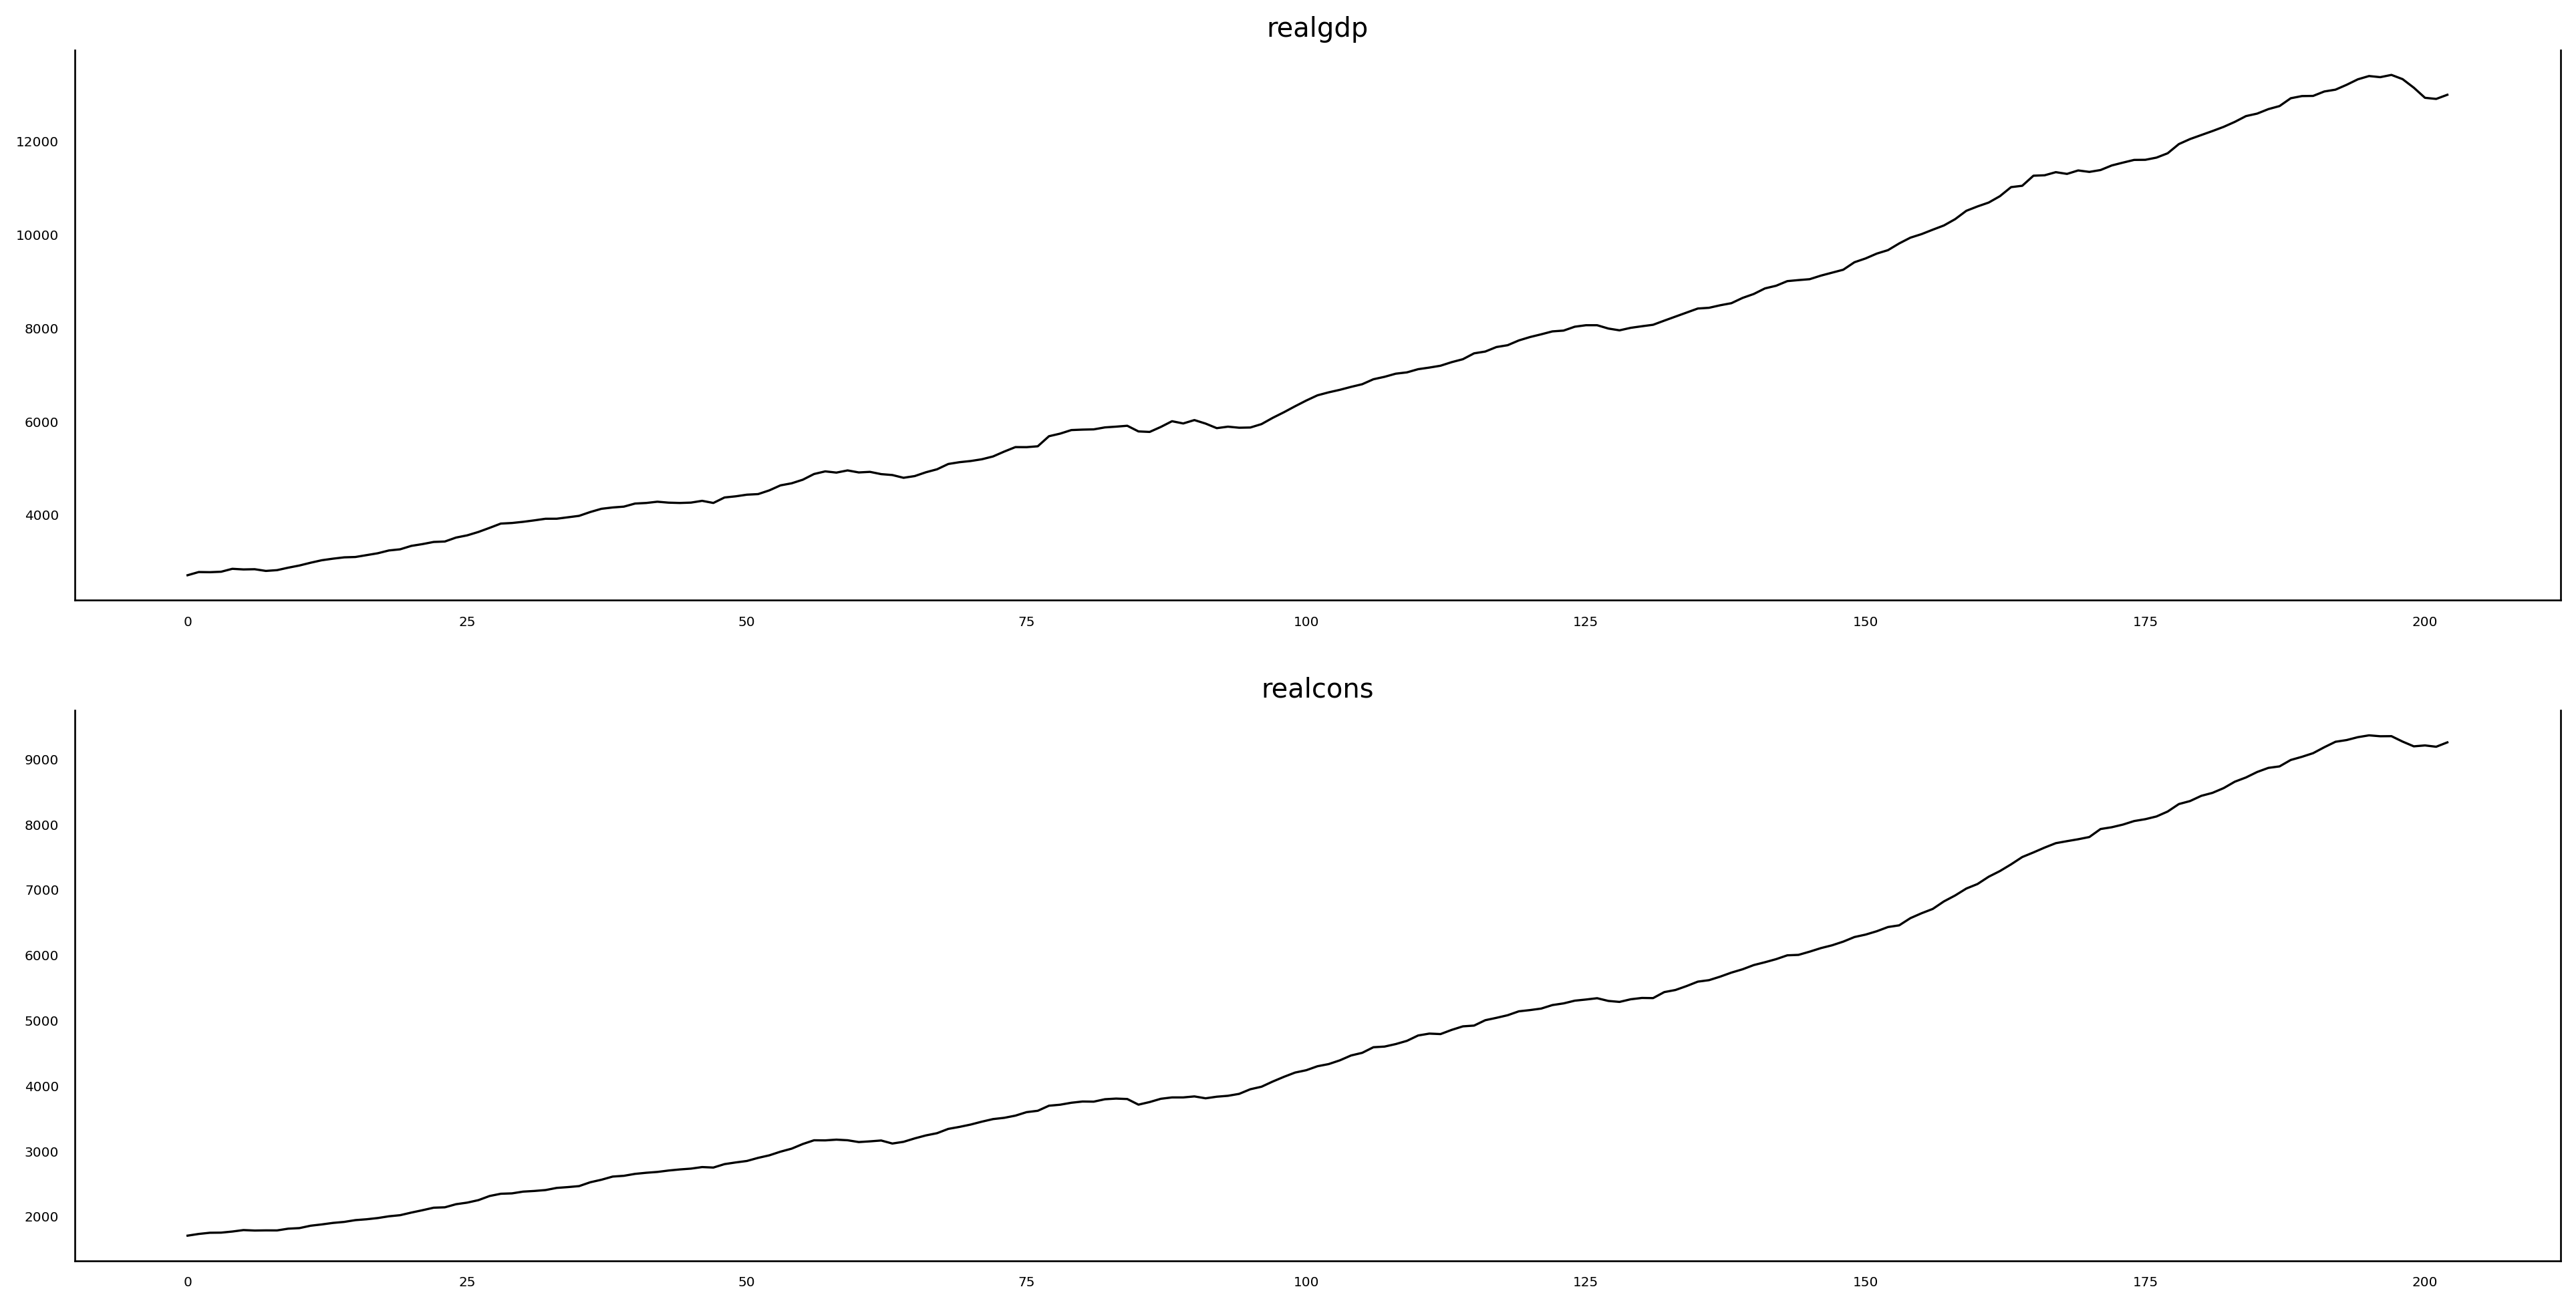

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=240)

ax1.plot(macro_data['realgdp'], color='black', linewidth=1)
ax1.set_title('realgdp')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize=6)

ax2.plot(macro_data['realcons'], color='black', linewidth=1)
ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize=6)


In [6]:
ad_fuller_result_1 = adfuller(macro_data['realgdp'].diff()[1:])

print('realgdp')
print(f'ADF Statistica: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n----------------------------------\n')

ad_fuller_result_2 = adfuller(macro_data['realcons'].diff()[1:])

print('realcons')
print(f'ADF Statistica: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')


realgdp
ADF Statistica: -6.305695561658105
p-value: 3.327882187668224e-08

----------------------------------

realcons
ADF Statistica: -4.204306080845245
p-value: 0.0006479282158627595


In [7]:
def optimize_VAR(endog):
    """
        Retorna um dataframe com parâmetros e seu correspondente MSE

    Args:
        endog: time series
    """

    results = []

    for i in tqdm_notebook(range(15)):
        try:
            model = VARMAX(endog, order=(i, 0)).fit(disp=False)
        except:
            continue

        mse = model.mse
        results.append([i, mse])

    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'mse']

    result_df = result_df.sort_values(
        by='mse', ascending=True).reset_index(drop=True)

    return result_df


In [8]:
endog = macro_data[['realgdp', 'realcons']]

result_df = optimize_VAR(endog)
result_df


  0%|          | 0/15 [00:00<?, ?it/s]

,p,mse
0,11,1.442852e+05
1,12,1.482786e+05
2,13,1.530864e+05
3,8,1.588906e+05
4,7,1.635689e+05
5,10,1.636941e+05
6,9,1.662454e+05
7,6,1.695968e+05
8,5,1.812595e+05
9,3,1.880532e+05


In [9]:
best_model = VARMAX(endog, order=(11, 0))
res = best_model.fit(disp=False)
print(res.summary())


                              Statespace Model Results                             
Dep. Variable:     ['realgdp', 'realcons']   No. Observations:                  203
Model:                             VAR(11)   Log Likelihood               -1985.764
                               + intercept   AIC                           4069.528
Date:                     Sat, 24 Sep 2022   BIC                           4231.875
Time:                             20:17:28   HQIC                          4135.207
Sample:                                  0                                         
                                     - 203                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.01, 0.08   Jarque-Bera (JB):           4.42, 9.05
Prob(Q):                        0.94, 0.77   Prob(JB):                   0.11, 0.01
Heteroskedasticity (H):         1.88, 2.48   Skew:                       0.3

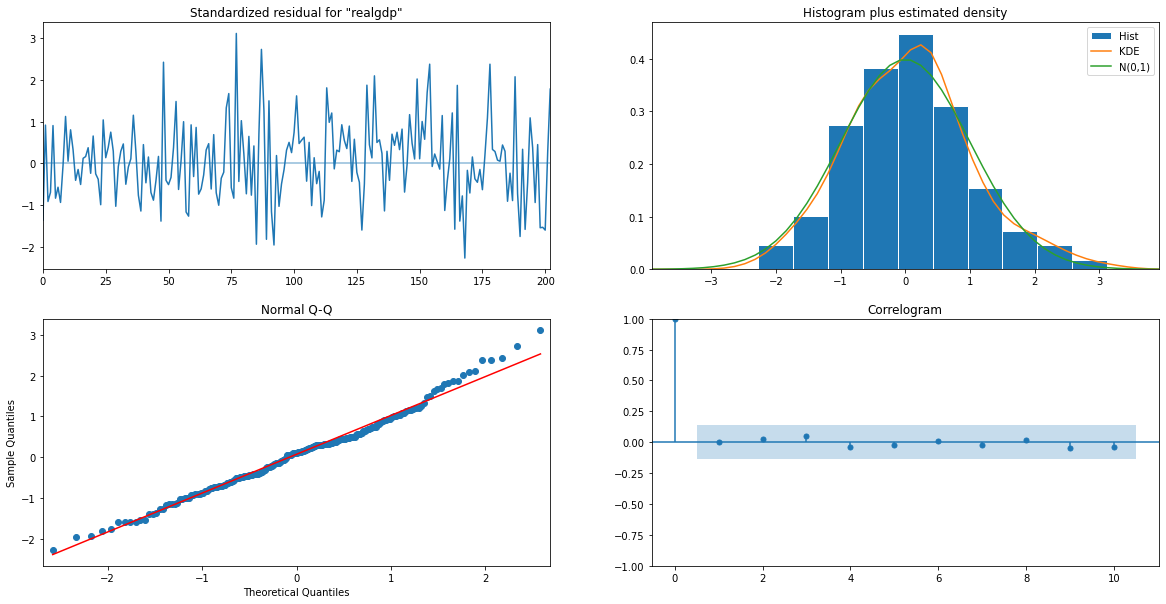

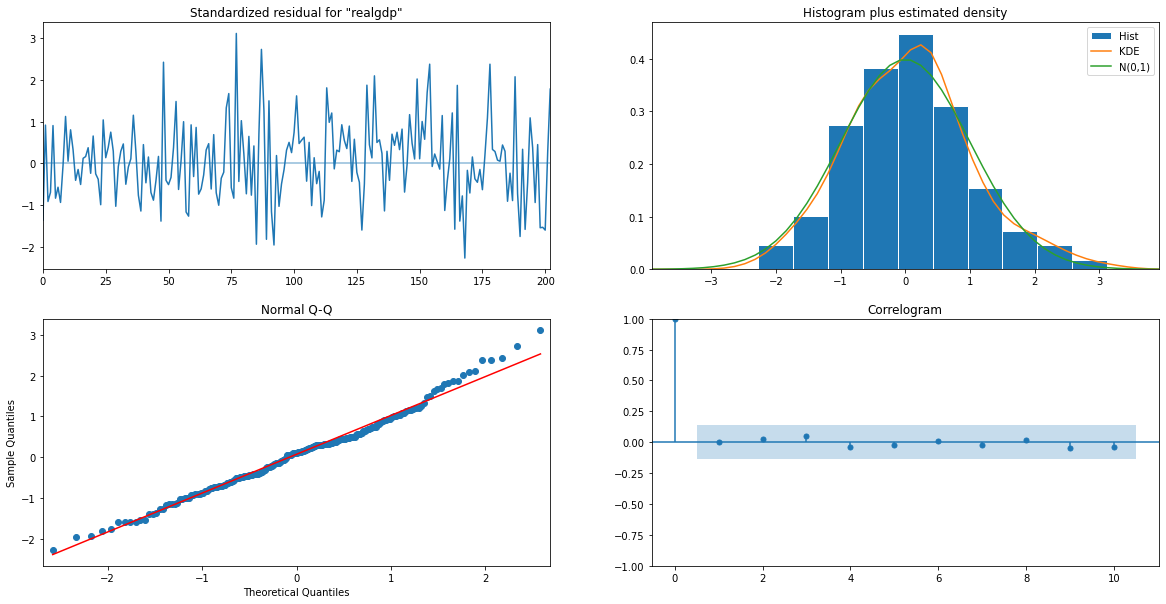

In [10]:
res.plot_diagnostics()


In [13]:
n_forecast = 3
predict = res.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

predict.predicted_mean.tail(3)


,realgdp,realcons
204,13160.375262,9293.310768
205,13187.998799,9295.260465
206,13227.920040,9296.615411


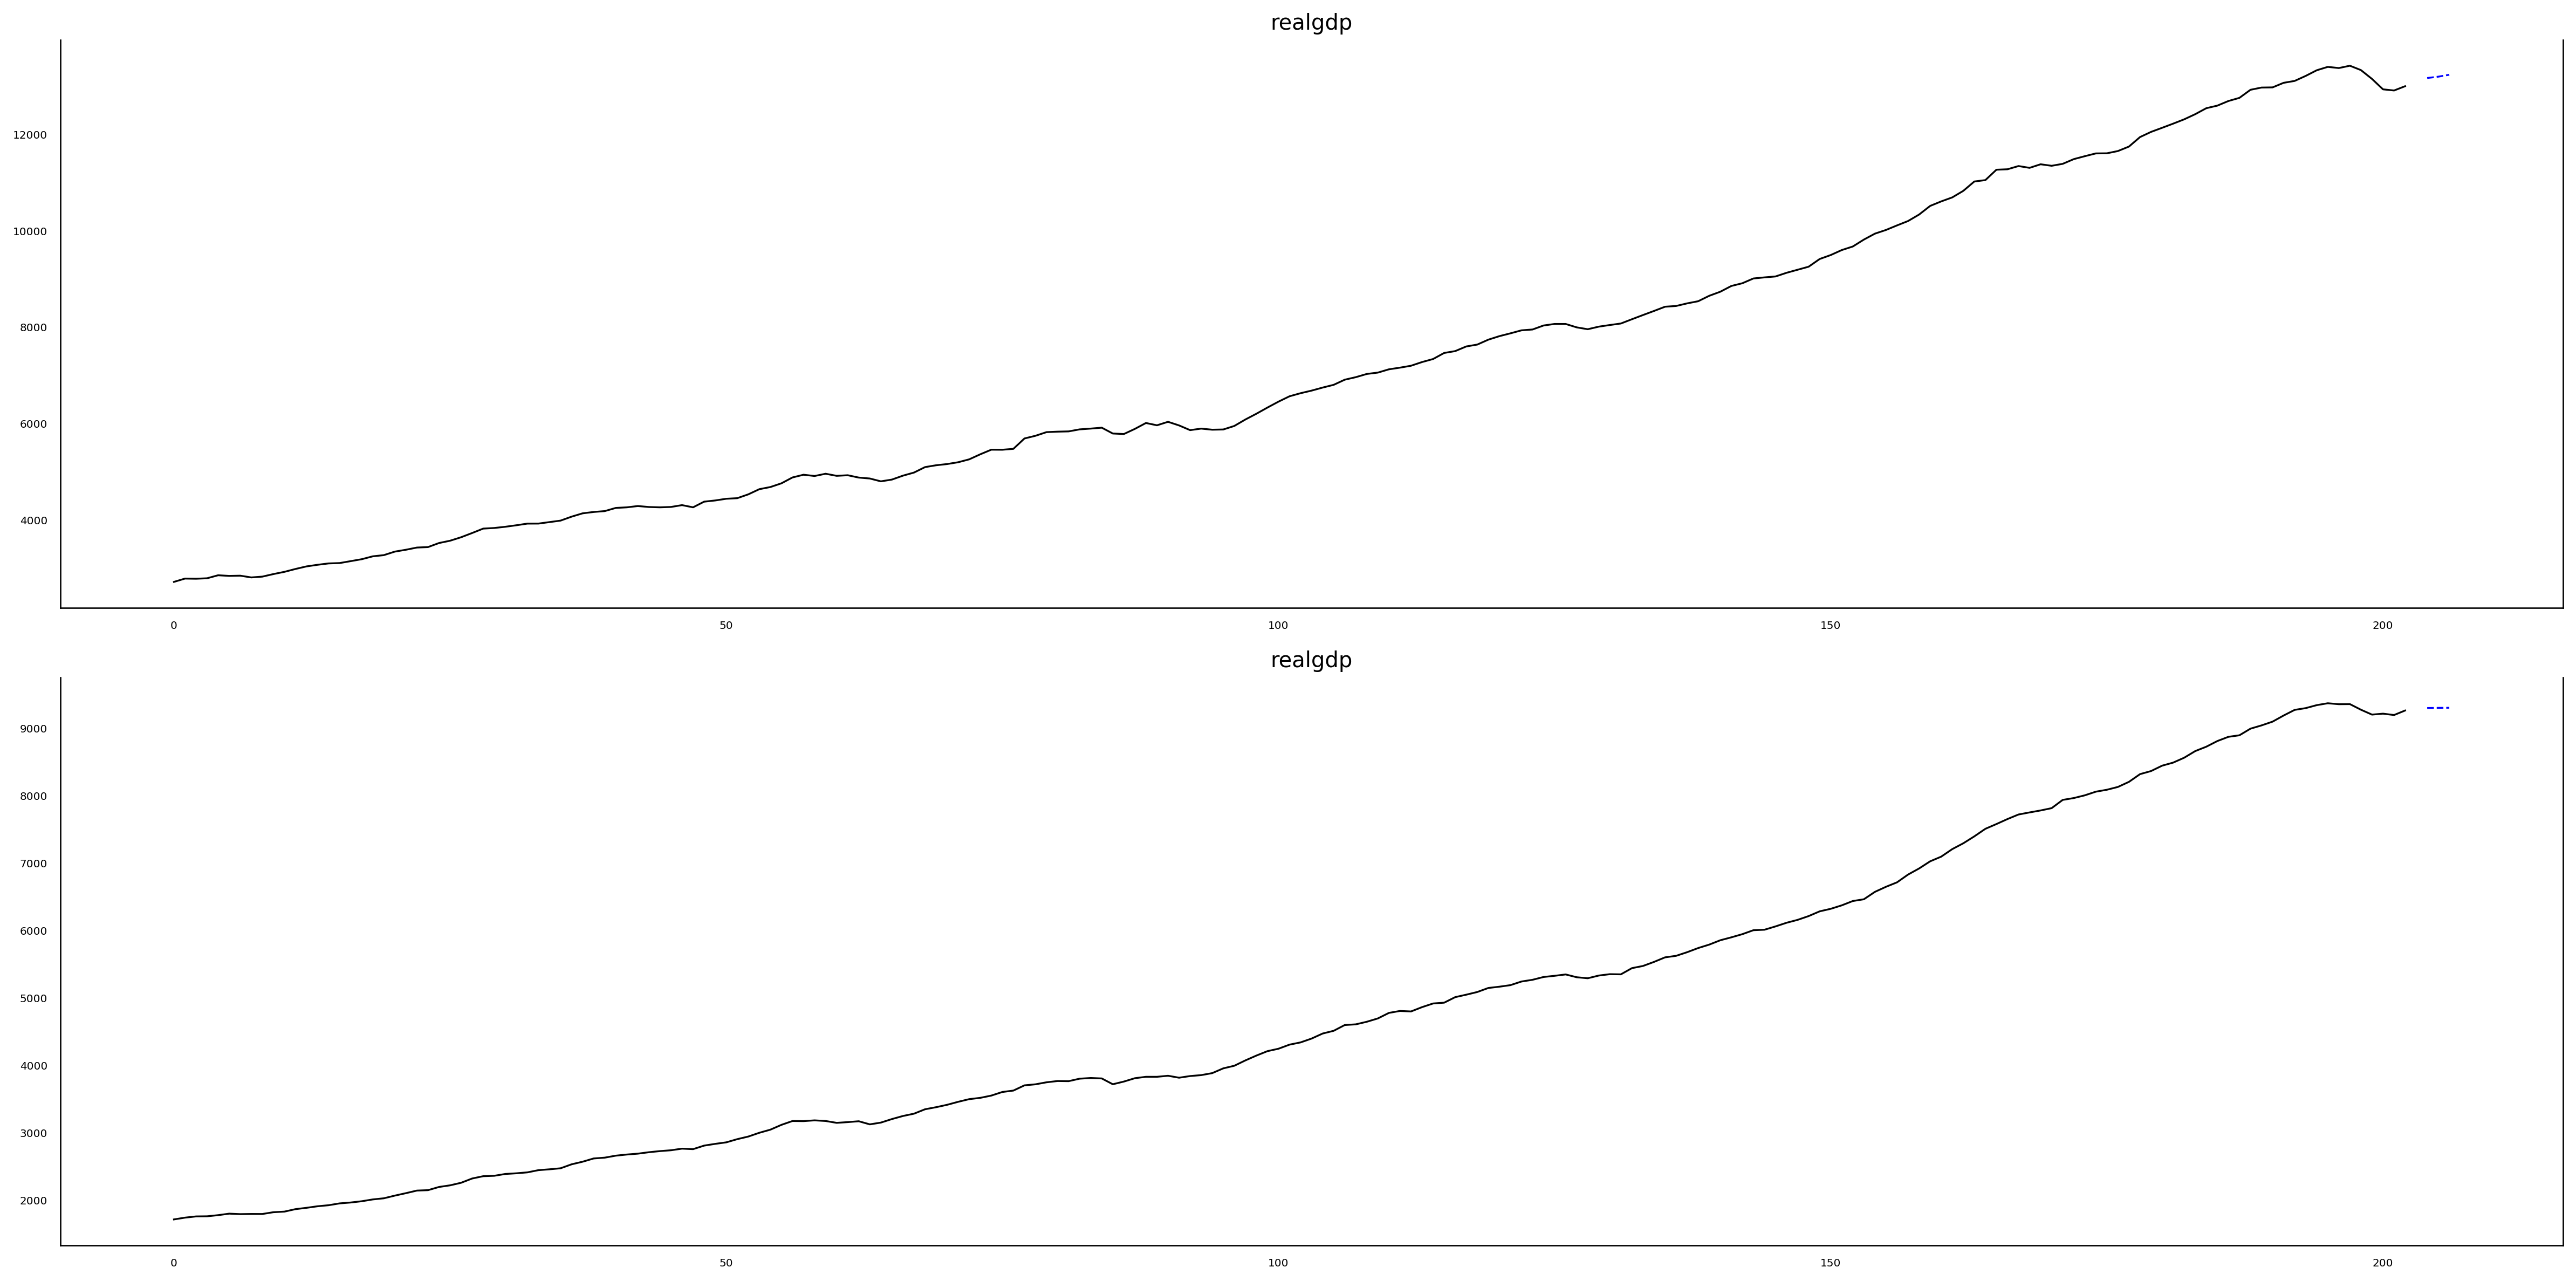

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=240)

ax1.plot(macro_data['realgdp'], color='black', linewidth=1)
ax1.plot(idx[-n_forecast:], 
         predict.predicted_mean['realgdp'][-n_forecast:], 
         color='blue',
         ls='--',
         linewidth=1
         )
ax1.set_title('realgdp')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize=6)

ax2.plot(macro_data['realcons'], color='black', linewidth=1)
ax2.plot(idx[-n_forecast:], 
         predict.predicted_mean['realcons'][-n_forecast:], 
         color='blue',
         ls='--',
         linewidth=1
         )
ax2.set_title('realgdp')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize=6)

plt.tight_layout()

In [18]:
print('realcons causa realgdp?\n')
print('--------------------------------')
granger_1 = grangercausalitytests(macro_data[['realgdp', 'realcons']].diff()[1:], [12])

print('\nrealgdp causa realcons?\n')
print('--------------------------------')
granger_2 = grangercausalitytests(macro_data[['realcons', 'realgdp']].diff()[1:], [12])

realcons causa realgdp?

--------------------------------

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=6.1144  , p=0.0000  , df_denom=165, df_num=12
ssr based chi2 test:   chi2=84.4900 , p=0.0000  , df=12
likelihood ratio test: chi2=69.8992 , p=0.0000  , df=12
parameter F test:         F=6.1144  , p=0.0000  , df_denom=165, df_num=12

realgdp causa realcons?

--------------------------------

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=2.1147  , p=0.0185  , df_denom=165, df_num=12
ssr based chi2 test:   chi2=29.2218 , p=0.0037  , df=12
likelihood ratio test: chi2=27.1813 , p=0.0073  , df=12
parameter F test:         F=2.1147  , p=0.0185  , df_denom=165, df_num=12


## VARMA

In [19]:
def optimize_VARMA(endog, parameters_list):
    """
        Retorma um dataframe com os parametros (p, q) e o MSE correspondente

    Args:
        endog: target
        parameters_list: lista de tuplas (p, q)
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model= VARMAX(endog, order=param).fit(disp=False)
        except:
            continue
        
        mse = model.mse 
        results.append([param, mse])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, q)', 'mse']
    
    result_df = result_df.sort_values(by='mse', ascending=True).reset_index(drop=True)
    
    return result_df

In [21]:
endog = macro_data[['realgdp', 'realcons']]

p = range(0, 4, 1)
q = range(0, 4, 1)

parameters = product(p,q)
parameters_list = list(parameters)

result_df_VARMA = optimize_VARMA(endog, parameters_list)
result_df_VARMA

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p, q)",mse
0,"(3, 3)",1.607716e+05
1,"(3, 2)",1.643546e+05
2,"(3, 1)",1.684850e+05
3,"(3, 0)",1.880532e+05
4,"(1, 1)",1.915088e+05
5,"(2, 1)",4.553035e+05
6,"(0, 1)",5.717763e+05
7,"(1, 2)",7.190591e+05
8,"(0, 3)",9.236038e+05
9,"(1, 3)",1.157557e+06


In [22]:
best_model_VARMA = VARMAX(endog, order=(3,3))

res_VARMA = best_model_VARMA.fit(disp=False)
print(res_VARMA.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realgdp', 'realcons']   No. Observations:                  203
Model:                          VARMA(3,3)   Log Likelihood               -1998.722
                               + intercept   AIC                           4055.445
Date:                     Sat, 24 Sep 2022   BIC                           4151.528
Time:                             23:02:11   HQIC                          4094.316
Sample:                                  0                                         
                                     - 203                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.00, 0.04   Jarque-Bera (JB):           4.96, 4.80
Prob(Q):                        0.98, 0.84   Prob(JB):                   0.08, 0.09
Heteroskedasticity (H):         2.30, 2.75   Skew:                       0.2

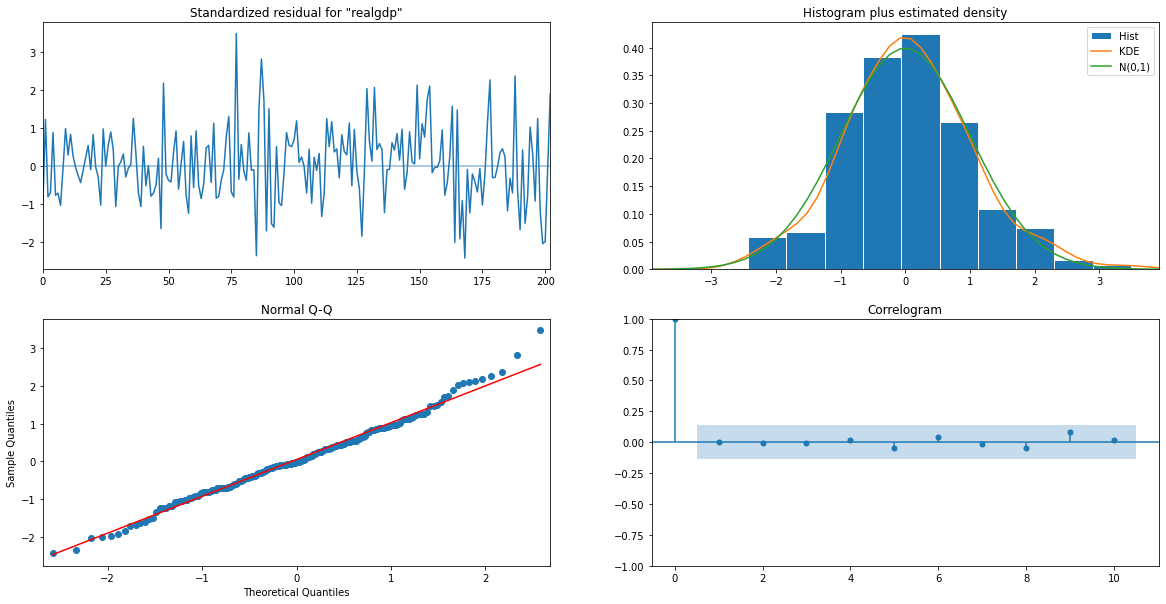

In [23]:
res_VARMA.plot_diagnostics();

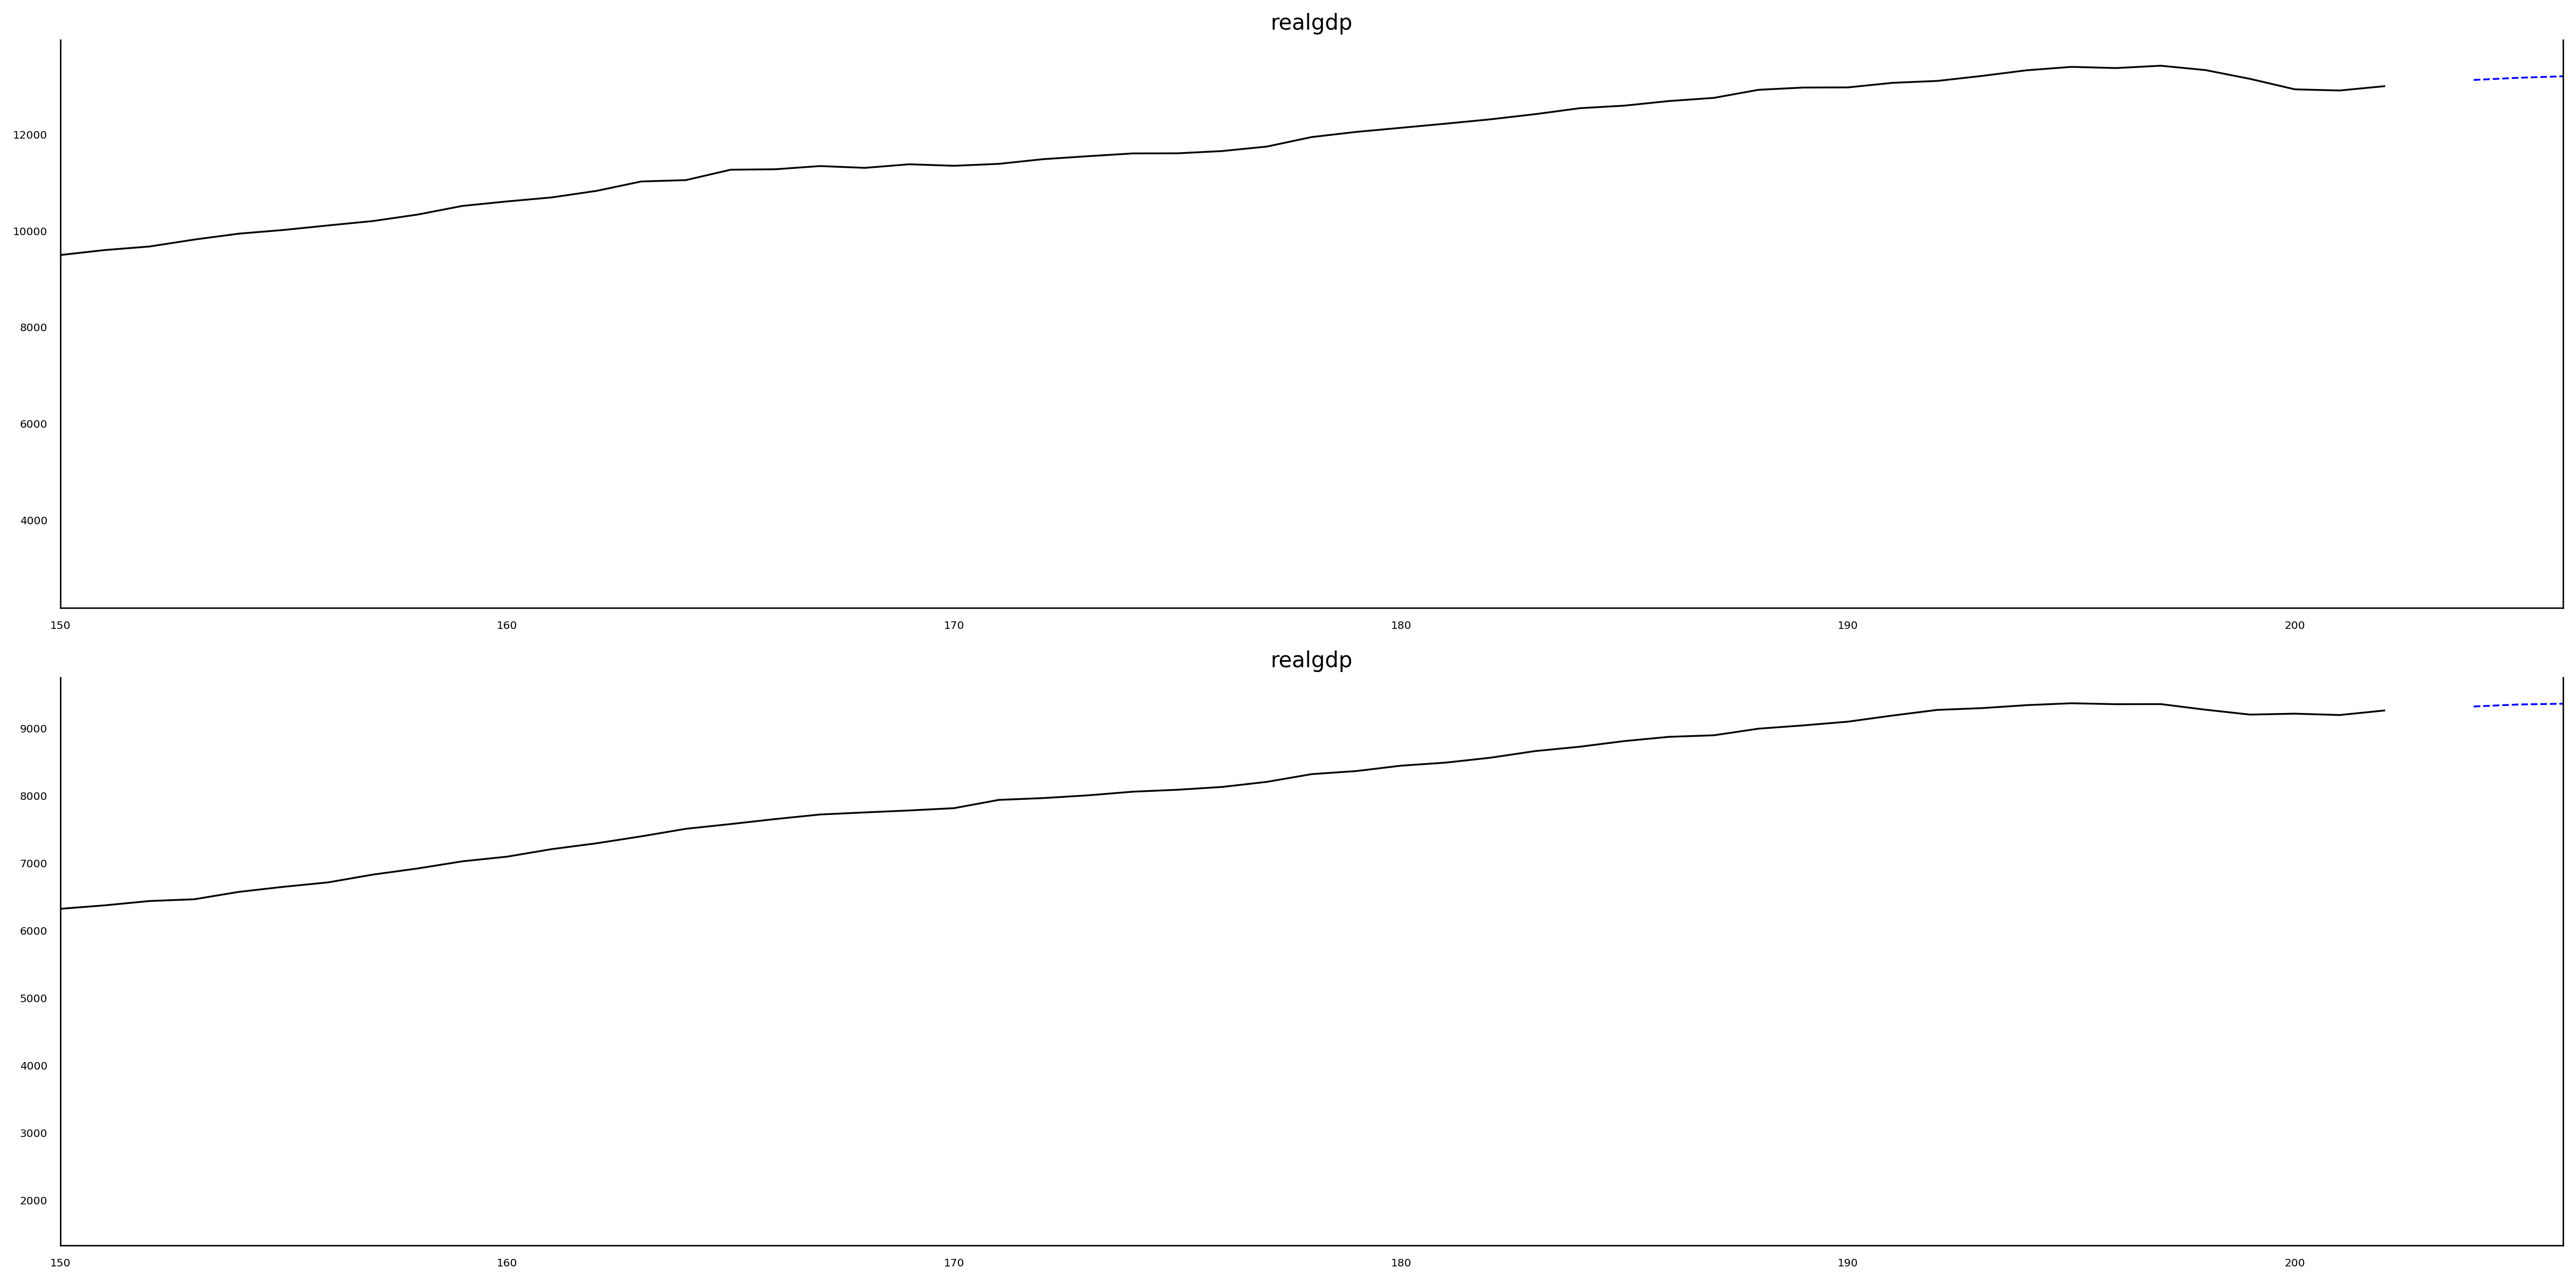

In [24]:
n_forecast = 3

predict = res_VARMA.get_prediction(end = best_model_VARMA.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=240)

ax1.plot(macro_data['realgdp'], color='black', linewidth=1)
ax1.plot(idx[-n_forecast:], 
         predict.predicted_mean['realgdp'][-n_forecast:], 
         color='blue',
         ls='--',
         linewidth=1
         )
ax1.set_title('realgdp')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.set_xlim(150,206)
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize=6)

ax2.plot(macro_data['realcons'], color='black', linewidth=1)
ax2.plot(idx[-n_forecast:], 
         predict.predicted_mean['realcons'][-n_forecast:], 
         color='blue',
         ls='--',
         linewidth=1
         )
ax2.set_title('realgdp')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.set_xlim(150,206)
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize=6)

plt.tight_layout()

## VARMAX

In [33]:
def optimize_VARMAX(endog, exog, parameters):
    """
        Retorna um dataframe com as duplas (p,q) e o MSE correspondente

    Args:
        endog: variaveis observadas - target
        exog: variáveis exógenas
        parameters: lista de tuplas (p, q)
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = VARMAX(endog, exog, order=param).fit(disp=False)
        except:
            continue
        
        mse = model.mse
        results.append([param, mse])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, q)', 'mse']
    
    result_df = result_df.sort_values(by='mse', ascending = True).reset_index(drop=True)
    
    return result_df

In [34]:
endog = macro_data[['realgdp', 'realcons']][:200]

exog_cols = macro_data.columns.drop(['year', 'quarter', 'realgdp', 'realcons'])
exog = macro_data[exog_cols][:200]

p = range(0, 4, 1)
q = range(0, 4, 1)

parameters = product(p,q)
parameters_list = list(parameters)

result_df_VARMAX = optimize_VARMAX(endog, exog, parameters_list)
result_df_VARMAX

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p, q)",mse
0,"(1, 3)",2317.210635
1,"(3, 3)",2322.372006
2,"(2, 3)",2343.218071
3,"(3, 2)",2365.061400
4,"(2, 2)",2397.324899
5,"(1, 2)",2431.296836
6,"(3, 1)",2465.096454
7,"(3, 0)",2519.682401
8,"(2, 1)",2539.431472
9,"(1, 0)",2559.287041


In [36]:
best_model_VARMAX = VARMAX(endog, exog, order=(1,3))

res_VARMAX = best_model_VARMAX.fit(disp=False)
print(res_VARMAX.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realgdp', 'realcons']   No. Observations:                  200
Model:                         VARMAX(1,3)   Log Likelihood               -1949.917
                               + intercept   AIC                           3981.835
Date:                     Sat, 24 Sep 2022   BIC                           4117.066
Time:                             23:45:29   HQIC                          4036.561
Sample:                                  0                                         
                                     - 200                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             3.11, 0.20   Jarque-Bera (JB):           7.00, 2.86
Prob(Q):                        0.08, 0.66   Prob(JB):                   0.03, 0.24
Heteroskedasticity (H):         1.59, 2.50   Skew:                       0.1

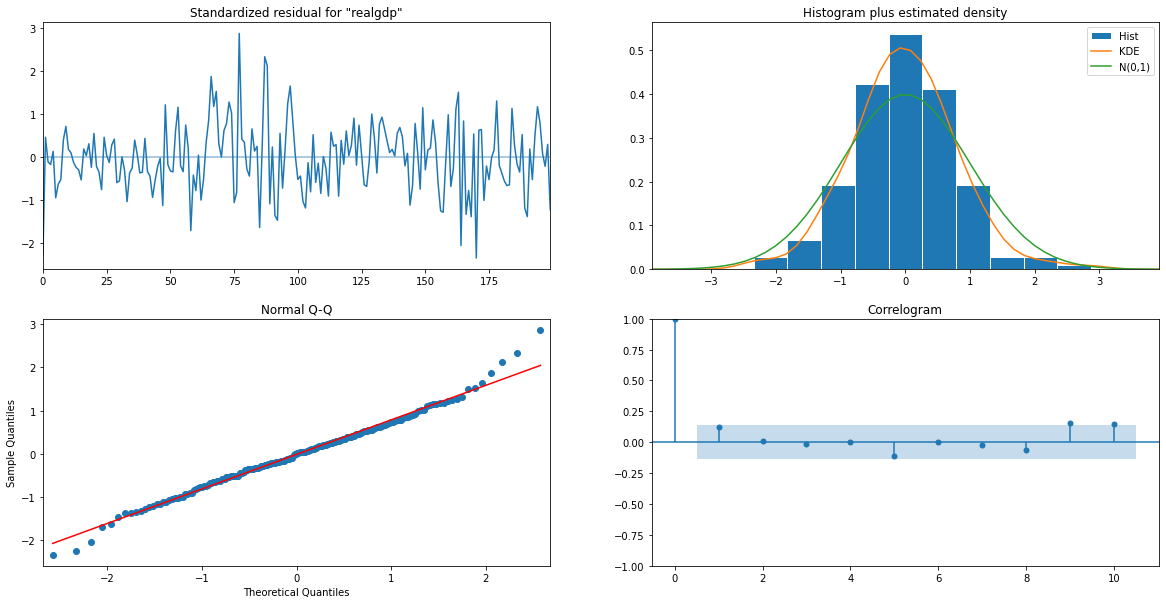

In [37]:
res_VARMAX.plot_diagnostics();

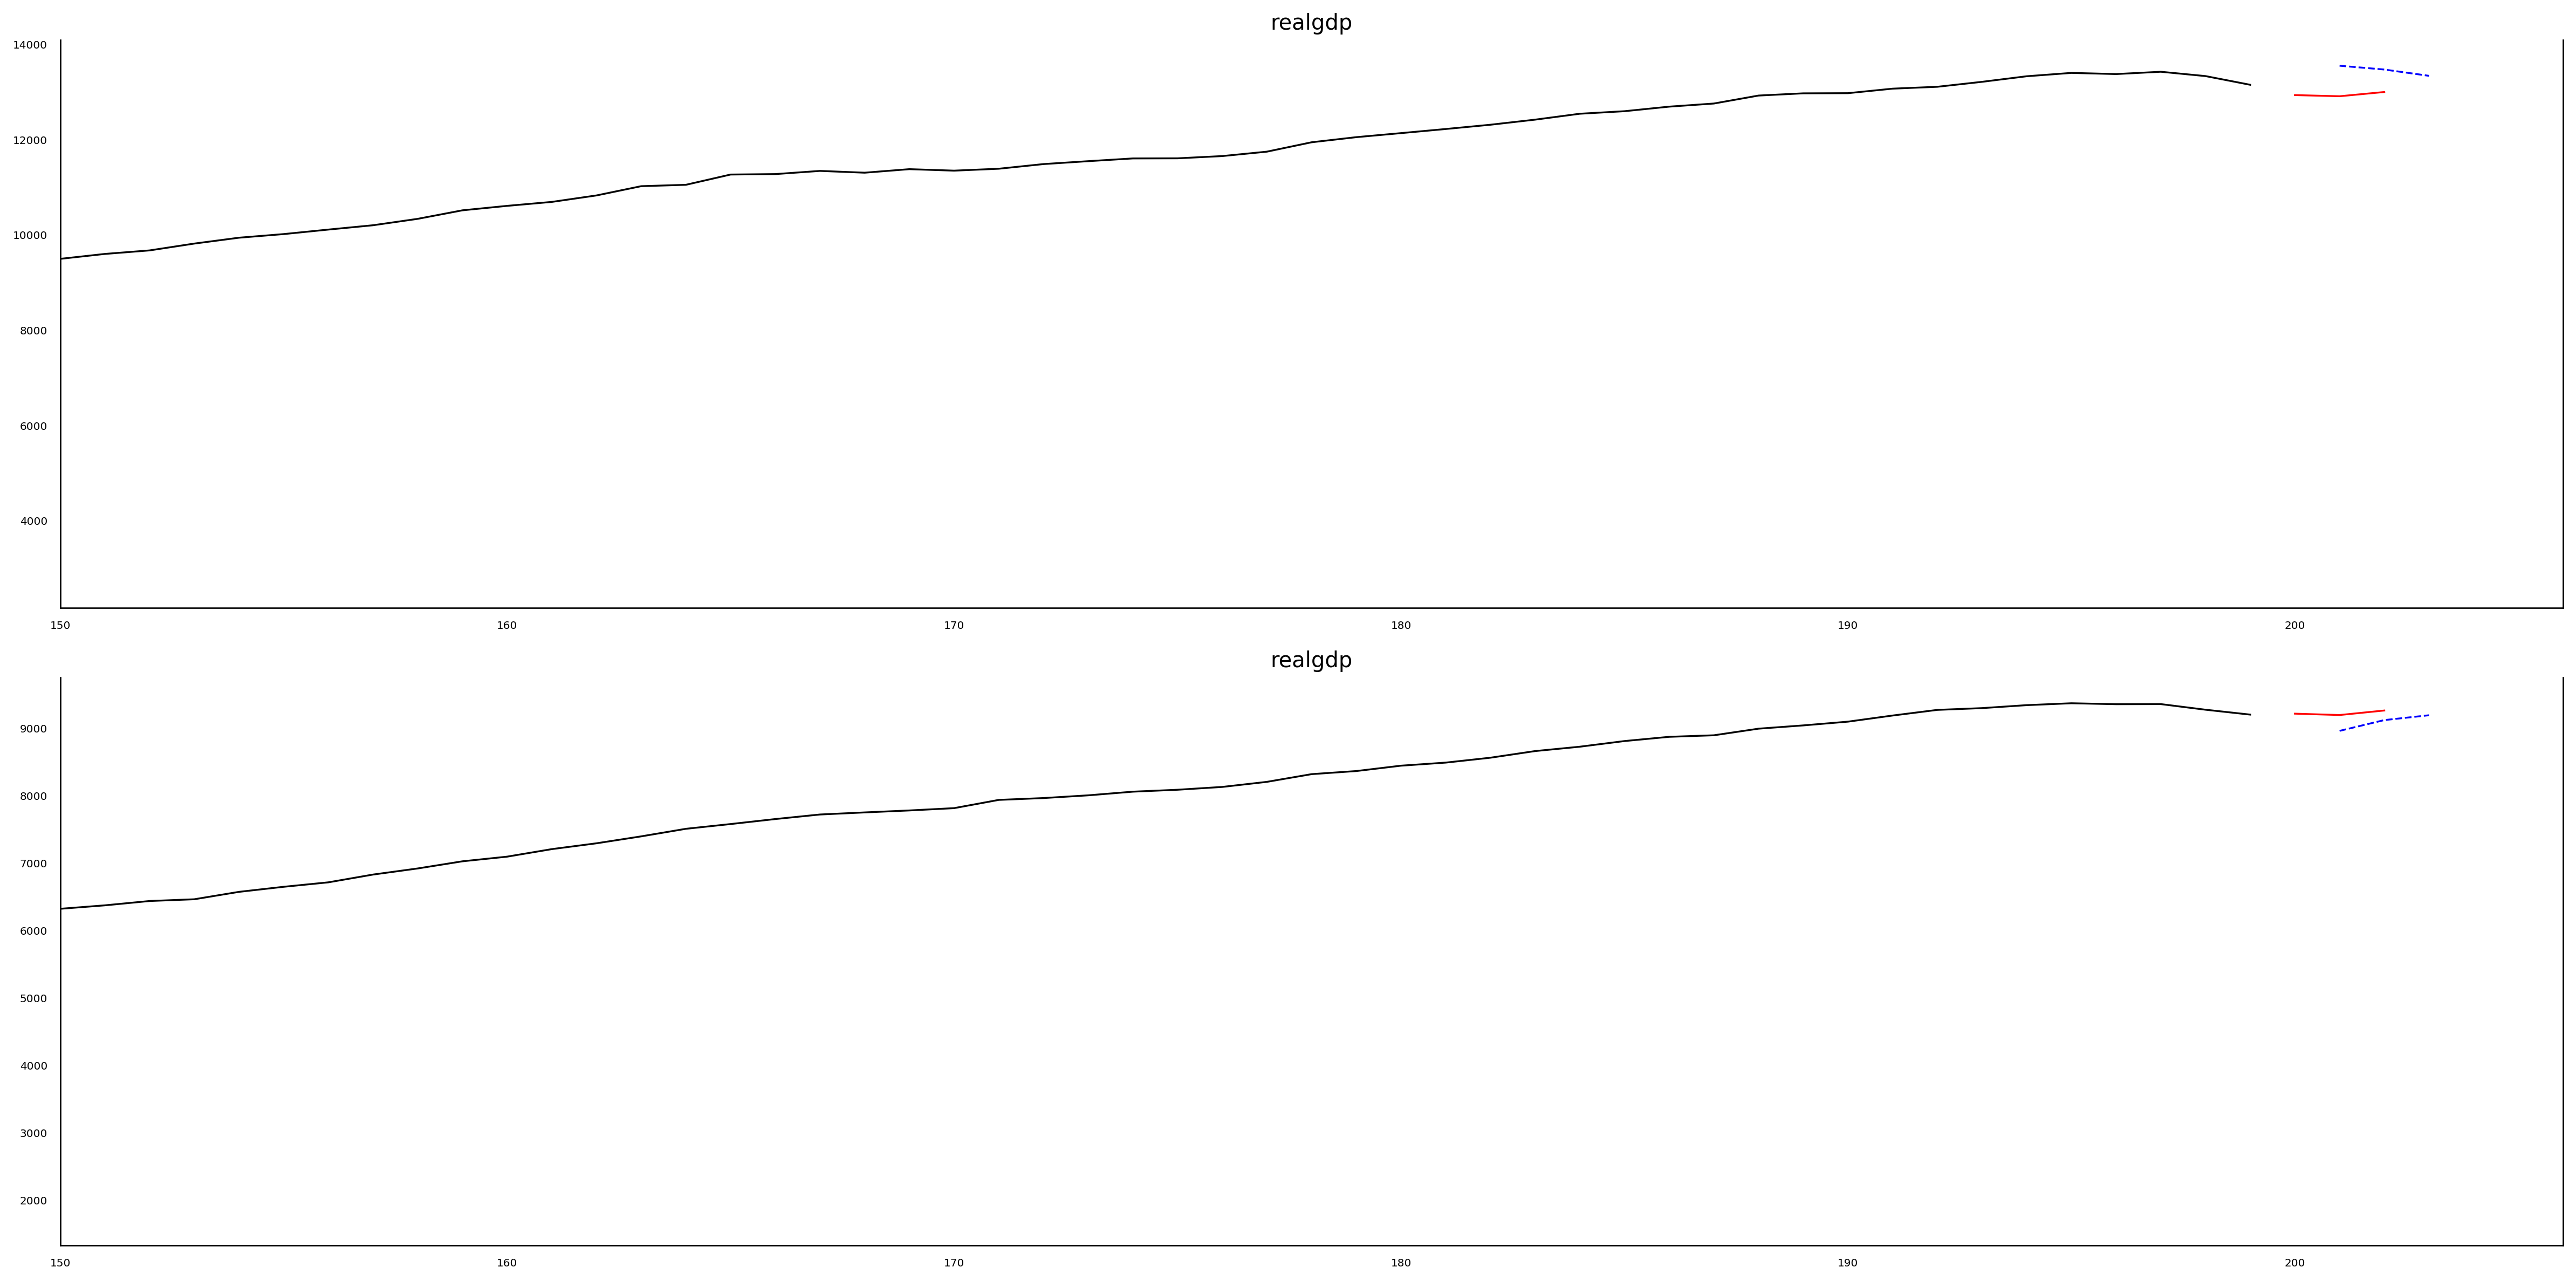

In [43]:
n_forecast = 3

predict = res_VARMAX.get_prediction(
    end = best_model_VARMAX.nobs + n_forecast, 
    exog = exog.iloc[-4:])

idx = np.arange(len(predict.predicted_mean))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=240)

ax1.plot(macro_data['realgdp'][:200], color='black', linewidth=1)
ax1.plot(macro_data['realgdp'][200:], color='red', linewidth=1)
ax1.plot(idx[-n_forecast:], 
         predict.predicted_mean['realgdp'][-n_forecast:], 
         color='blue',
         ls='--',
         linewidth=1
         )
ax1.set_title('realgdp')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.set_xlim(150,206)
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize=6)

ax2.plot(macro_data['realcons'][:200], color='black', linewidth=1)
ax2.plot(macro_data['realcons'][200:], color='red', linewidth=1)
ax2.plot(idx[-n_forecast:], 
         predict.predicted_mean['realcons'][-n_forecast:], 
         color='blue',
         ls='--',
         linewidth=1
         )
ax2.set_title('realgdp')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.set_xlim(150,206)
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize=6)

plt.tight_layout()